# MountainCarContinuous

# DDPG

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import copy
import matplotlib.pyplot as plt 

In [2]:
# Создание среды
env = gym.make("MountainCarContinuous-v0")

# Гиперпараметры
STATE_DIM = env.observation_space.shape[0]  # 2
ACTION_DIM = env.action_space.shape[0]  # 1
ACTOR_LR = 0.0001
CRITIC_LR = 0.001
GAMMA = 0.99
TAU = 0.001
BUFFER_SIZE = 100000
BATCH_SIZE = 64

In [3]:
# Определение Actor
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, action_dim)
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.tanh(self.fc3(x))

# Определение Critic
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [14]:
# Буфер воспроизведения
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def size(self):
        return len(self.buffer)
# Ornstein-Uhlenbeck Noise
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [ ]:
# Создание сетей и оптимизаторов
actor = Actor(STATE_DIM, ACTION_DIM)
critic = Critic(STATE_DIM, ACTION_DIM)
target_actor = Actor(STATE_DIM, ACTION_DIM)
target_critic = Critic(STATE_DIM, ACTION_DIM)

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)

replay_buffer = ReplayBuffer(BUFFER_SIZE)
noise = OUNoise(ACTION_DIM)

target_actor.requires_grad_(False)
target_critic.requires_grad_(False)


# Копирование весов
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Функция мягкого обновления весов
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

In [6]:
# Функция обучения
def train():
    if replay_buffer.size() < BATCH_SIZE:
        return
    batch = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)
    
    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.float32)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
    dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)
    
    # Обновление Critic
    next_actions = target_actor(next_states)
    target_q = target_critic(next_states, next_actions)
    expected_q = rewards + GAMMA * target_q * (1 - dones)
    current_q = critic(states, actions)
    
    critic_loss = nn.MSELoss()(current_q, expected_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    # Обновление Actor
    actor_loss = -critic(states, actor(states)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    # Soft update
    soft_update(target_actor, actor, TAU)
    soft_update(target_critic, critic, TAU)

In [7]:
# Запуск обучения
episodes = 200
total_timesteps = 0
reward_history = []
for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()  # Сброс шума в начале эпизода
    
    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]
        
        noise_sample = noise.sample()
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)
        
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        train()
        state = next_state
        episode_reward += reward
        total_timesteps += 1
        
        if done:
            break
    
    print(f"Эпизод {episode + 1}, Награда: {episode_reward}")
    reward_history.append(episode_reward)

env.close()

Эпизод 1, Награда: -14.1356903314715
Эпизод 2, Награда: -13.425440297185625
Эпизод 3, Награда: -12.15345550543354
Эпизод 4, Награда: -14.567088865555709
Эпизод 5, Награда: -17.292292690207706
Эпизод 6, Награда: -12.613421611869867
Эпизод 7, Награда: -13.444148817745296
Эпизод 8, Награда: -16.504697031888323
Эпизод 9, Награда: 84.84222096353909
Эпизод 10, Награда: 90.84553678159087
Эпизод 11, Награда: -14.567143310530641
Эпизод 12, Награда: -15.533011537524807
Эпизод 13, Награда: -17.182421081214017
Эпизод 14, Награда: 85.11186492434966
Эпизод 15, Награда: 84.0402371744228
Эпизод 16, Награда: 91.76175563483167
Эпизод 17, Награда: -18.948291823841174
Эпизод 18, Награда: -18.989720067290115
Эпизод 19, Награда: -15.016635399624398
Эпизод 20, Награда: 85.47979120302216
Эпизод 21, Награда: -15.247254509170276
Эпизод 22, Награда: 87.5687088864342
Эпизод 23, Награда: 83.04658921661719
Эпизод 24, Награда: -16.85891209442935
Эпизод 25, Награда: 79.06497161559972
Эпизод 26, Награда: -15.372066017

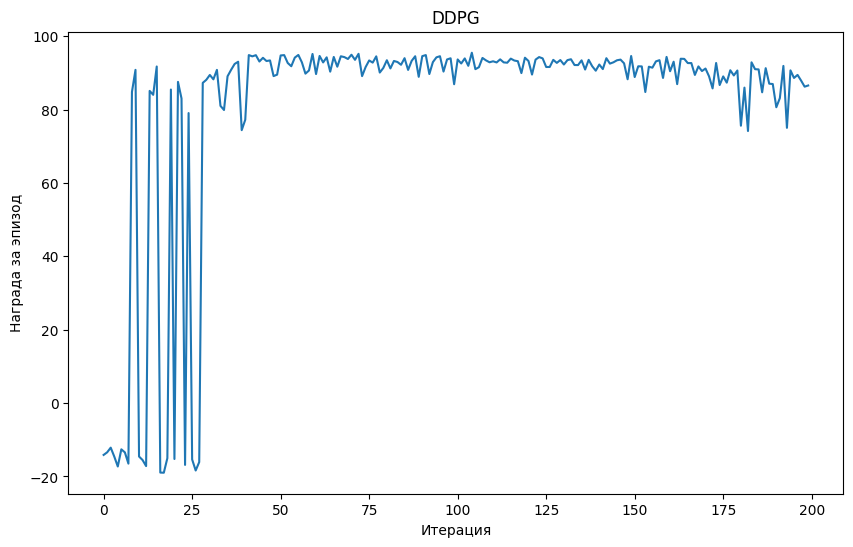

In [13]:
plt.figure(figsize=(10,6))
plt.plot(reward_history)
plt.xlabel("Итерация")
plt.ylabel("Награда за эпизод")
plt.title("DDPG")
plt.savefig("graph")

In [ ]:
# Обучение прошло нормально. модель выучила политику

# AC2

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import copy

# Создание среды
env = gym.make("MountainCarContinuous-v0")

# Гиперпараметры
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
ACTOR_LR = 0.0003
CRITIC_LR = 0.001
GAMMA = 0.99

# Ornstein-Uhlenbeck Noise для исследования
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state += dx
        return self.state

# Акторная сеть (политика)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = torch.tanh(self.mean(x))
        log_std = torch.clamp(self.log_std(x), -2, 2)  # Ограничиваем дисперсию
        std = torch.exp(log_std)
        return mean, std

# Критик (оценка состояния)
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Создание моделей
actor = Actor(STATE_DIM, ACTION_DIM)
critic = Critic(STATE_DIM)

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)

noise = OUNoise(ACTION_DIM)  # Инициализируем шум

# Функция обучения
def train(state, action, reward, next_state, done):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
    reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    done = torch.tensor(done, dtype=torch.float32).unsqueeze(0)

    # Оценки значений состояний
    value = critic(state)
    next_value = critic(next_state).detach()
    advantage = reward + (1 - done) * GAMMA * next_value - value

    # Вычисляем логарифм вероятности действия
    mean, std = actor(state)
    dist = torch.distributions.Normal(mean, std)
    log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)

    # Энтропия для исследования (добавляет стохастичность)
    entropy_bonus = dist.entropy().mean()

    # Потери актора и критика
    actor_loss = -(log_prob * advantage.detach()).mean() - 0.01 * entropy_bonus
    critic_loss = advantage.pow(2).mean()

    # Обновление актора
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Обновление критика
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

# Запуск обучения
episodes = 200
reward_history = []
for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()  # Сброс шума в начале эпизода
    
    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        mean, std = actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample().numpy()[0]

        # Добавляем шум, но уменьшаем его со временем
        noise_sample = noise.sample() * max(0.1, 1 - episode / 200)
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)

        next_state, reward, done, _, _ = env.step(action)
        train(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        if done:
            break

    print(f"Эпизод {episode + 1}, Награда: {episode_reward}")
    reward_history.append(episode_reward)

env.close()


Эпизод 1, Награда: 9.524379613204317
Эпизод 2, Награда: -92.97297315747254
Эпизод 3, Награда: -93.55869590376
Эпизод 4, Награда: -92.76518844704442
Эпизод 5, Награда: -92.87523586098342
Эпизод 6, Награда: -92.1729651500035
Эпизод 7, Награда: -92.80020406202033
Эпизод 8, Награда: -92.9451841349885
Эпизод 9, Награда: -91.97303866232866
Эпизод 10, Награда: -92.38060779301308
Эпизод 11, Награда: 32.014677667283195
Эпизод 12, Награда: 8.34002556650249
Эпизод 13, Награда: -92.02966657161139
Эпизод 14, Награда: -92.30554939485762
Эпизод 15, Награда: -93.13584003214966
Эпизод 16, Награда: -92.94045219918726
Эпизод 17, Награда: -95.33531940563998
Эпизод 18, Награда: 21.139992648710006
Эпизод 19, Награда: 21.983155892534384
Эпизод 20, Награда: -91.56180135699198
Эпизод 21, Награда: -93.61958968158346
Эпизод 22, Награда: 52.1204279346759
Эпизод 23, Награда: -93.15816261204195
Эпизод 24, Награда: -92.01327900534307
Эпизод 25, Награда: -93.65295246332427
Эпизод 26, Награда: -93.25381059993029
Эпизо

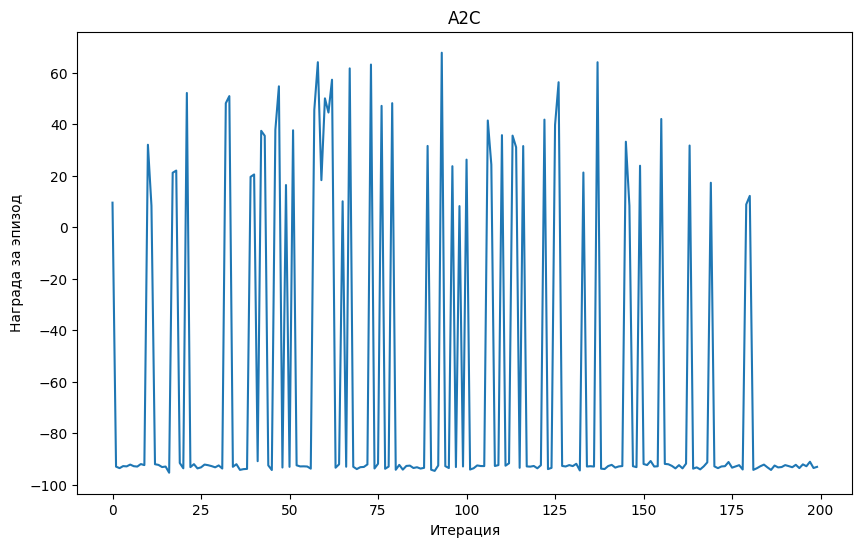

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(reward_history)
plt.xlabel("Итерация")
plt.ylabel("Награда за эпизод")
plt.title("A2C")
plt.savefig("graph")

In [ ]:
#обучение не происходит

In [ ]:
#попробуем сделать более стабильным через добавление target critic

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import copy

# Создание среды
env = gym.make("MountainCarContinuous-v0")

# Гиперпараметры
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
ACTOR_LR = 0.0003
CRITIC_LR = 0.001
GAMMA = 0.99
TAU = 0.005  # Коэффициент обновления целевого критика

# Ornstein-Uhlenbeck Noise для исследования
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state += dx
        return self.state

# Акторная сеть (политика)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = torch.tanh(self.mean(x))
        log_std = torch.clamp(self.log_std(x), -2, 2)
        std = torch.exp(log_std)
        return mean, std

# Критик (оценка состояния)
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Создание моделей
actor = Actor(STATE_DIM, ACTION_DIM)
critic = Critic(STATE_DIM)
target_critic = Critic(STATE_DIM)
target_critic.load_state_dict(critic.state_dict())  # Инициализация весов

target_critic.eval()

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)



target_critic.requires_grad_(False)

noise = OUNoise(ACTION_DIM)

def soft_update(target, source, tau):
    with torch.no_grad():
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

# Функция обучения
def train(state, action, reward, next_state, done):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
    reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    done = torch.tensor(done, dtype=torch.float32).unsqueeze(0)

    value = critic(state)
    next_value = target_critic(next_state).detach()
    advantage = reward + (1 - done) * GAMMA * next_value - value

    mean, std = actor(state)
    dist = torch.distributions.Normal(mean, std)
    log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)

    entropy_bonus = dist.entropy().mean()
    actor_loss = -(log_prob * advantage.detach()).mean() - 0.01 * entropy_bonus
    critic_loss = advantage.pow(2).mean()

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    soft_update(target_critic, critic, TAU)

# Запуск обучения
episodes = 100
reward_history = []
for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()
    noise_level = max(0.1, 1 - episode / episodes)  # Плавное уменьшение шума

    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        mean, std = actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample().numpy()[0]

        noise_sample = noise.sample() * noise_level
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)

        next_state, reward, done, _, _ = env.step(action)
        train(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        if done:
            break

    print(f"Эпизод {episode + 1}, Награда: {episode_reward}")
    reward_history.append(episode_reward)

env.close()


Эпизод 1, Награда: 85.56334129927998
Эпизод 2, Награда: -33.25787656862072
Эпизод 3, Награда: -26.793359529903732
Эпизод 4, Награда: 87.90454602340056
Эпизод 5, Награда: 87.61642964380427
Эпизод 6, Награда: 89.59785261553489
Эпизод 7, Награда: 79.73885544917425
Эпизод 8, Награда: 80.68330513326244
Эпизод 9, Награда: 77.4562426394226
Эпизод 10, Награда: 77.92502457919605
Эпизод 11, Награда: 62.4430908771946
Эпизод 12, Награда: 71.87655590763578
Эпизод 13, Награда: -35.99571449599975
Эпизод 14, Награда: 76.32230769325025
Эпизод 15, Награда: 80.04972264089118
Эпизод 16, Награда: 75.73167731767234
Эпизод 17, Награда: 73.00284801688454
Эпизод 18, Награда: 78.31808428655441
Эпизод 19, Награда: 86.84680048318202
Эпизод 20, Награда: 92.63431342809169
Эпизод 21, Награда: -42.170028639786786
Эпизод 22, Награда: -37.42080521570183
Эпизод 23, Награда: 72.60140734325688
Эпизод 24, Награда: 86.91490259837158
Эпизод 25, Награда: 61.64563372028075
Эпизод 26, Награда: 48.55445675595253
Эпизод 27, Награ

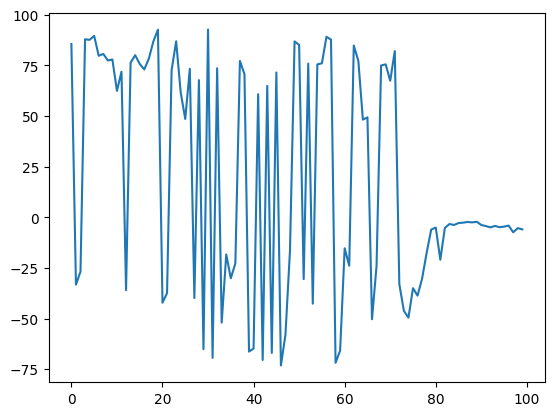

In [7]:
plt.plot(reward_history)

In [ ]:
# Значительно лучше но все равно плохо
# Сделаем шум более постоянным

In [8]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy

# Создание среды
env = gym.make("MountainCarContinuous-v0")

# Гиперпараметры
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
ACTOR_LR = 0.0003
CRITIC_LR = 0.001
GAMMA = 0.99
TAU = 0.005  # Коэффициент soft-update

# Ornstein-Uhlenbeck Noise для исследования
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state += dx
        return self.state

# Акторная сеть (политика)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = torch.tanh(self.mean(x))
        log_std = torch.clamp(self.log_std(x), -2, 2)
        std = torch.exp(log_std)
        return mean, std

# Критик (оценка состояния)
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Soft update для целевого критика
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

# Создание моделей
actor = Actor(STATE_DIM, ACTION_DIM)
critic = Critic(STATE_DIM)
target_critic = Critic(STATE_DIM)
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)

noise = OUNoise(ACTION_DIM)  # Инициализируем шум

# Функция обучения
def train(state, action, reward, next_state, done):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
    reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    done = torch.tensor(done, dtype=torch.float32).unsqueeze(0)

    # Оценки значений состояний
    value = critic(state)
    next_value = target_critic(next_state).detach()
    advantage = reward + (1 - done) * GAMMA * next_value - value

    # Вычисляем логарифм вероятности действия
    mean, std = actor(state)
    dist = torch.distributions.Normal(mean, std)
    log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)

    # Энтропия для исследования
    entropy_bonus = dist.entropy().mean()

    # Потери актора и критика
    actor_loss = -(log_prob * advantage.detach()).mean() - 0.01 * entropy_bonus
    critic_loss = advantage.pow(2).mean()

    # Обновление актора
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Обновление критика
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Обновление целевого критика
    soft_update(target_critic, critic, TAU)

# Запуск обучения
episodes = 200
reward_history = []
for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()  # Сброс шума в начале эпизода
    
    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        mean, std = actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample().numpy()[0]

        # Добавляем постоянный шум
        noise_sample = noise.sample()
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)

        next_state, reward, done, _, _ = env.step(action)
        train(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        if done:
            break

    print(f"Эпизод {episode + 1}, Награда: {episode_reward}")
    reward_history.append(episode_reward)

env.close()


Эпизод 1, Награда: 78.97415829350723
Эпизод 2, Награда: 72.81762810036949
Эпизод 3, Награда: 87.65885054586474
Эпизод 4, Награда: 64.81306018276226
Эпизод 5, Награда: 73.93933371279007
Эпизод 6, Награда: 49.23319589562454
Эпизод 7, Награда: 93.96483253142087
Эпизод 8, Награда: 81.65934064669045
Эпизод 9, Награда: 72.93578837334337
Эпизод 10, Награда: 62.13735039962419
Эпизод 11, Награда: 51.791768884717044
Эпизод 12, Награда: 78.93838863319176
Эпизод 13, Награда: -70.43542864768791
Эпизод 14, Награда: 77.16070262150161
Эпизод 15, Награда: 51.132836834425184
Эпизод 16, Награда: -68.89040312250582
Эпизод 17, Награда: 74.17085755097766
Эпизод 18, Награда: 72.62985827224699
Эпизод 19, Награда: 35.79606820875975
Эпизод 20, Награда: -68.79806450493899
Эпизод 21, Награда: 76.88471969241478
Эпизод 22, Награда: 41.9923960677205
Эпизод 23, Награда: -70.96111524068368
Эпизод 24, Награда: -63.69846832202737
Эпизод 25, Награда: 59.82616946749649
Эпизод 26, Награда: 87.55274183707682
Эпизод 27, Нагр

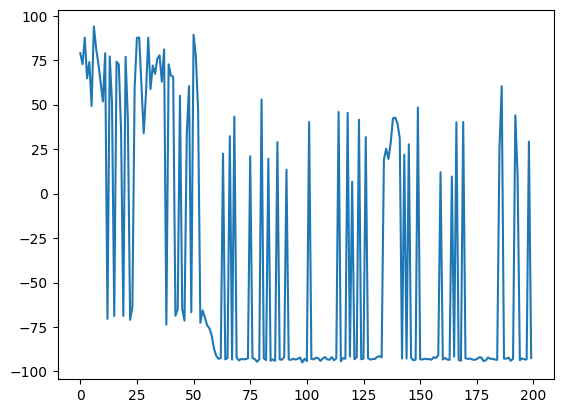

In [9]:
plt.plot(reward_history)

In [ ]:
#A2C не сильно стабилен в данной задаче
#Связано возможно с непрырвыноым пространством действий и стохастическим выбором следующего шага из распредления, что делает алгоритм не сильно стабильным
#Подберем лучший набор параметров для DDPG через optuna

# Optuna optimization

In [10]:
import optuna

d:\RL_course\RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Ornstein-Uhlenbeck Noise для исследования
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state += dx
        return self.state

# Буфер опыта
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Акторная сеть (политика)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

# Критик (оценка состояния)
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Функция тренировки
def train(actor, critic, target_actor, target_critic, actor_optimizer, critic_optimizer, replay_buffer, batch_size, gamma, tau):
    if len(replay_buffer) < batch_size:
        return

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.float32)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
    dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)

    # Обновление критика
    with torch.no_grad():
        target_actions = target_actor(next_states)
        target_q = target_critic(next_states, target_actions)
        target_q = rewards + (1 - dones) * gamma * target_q

    critic_loss = nn.MSELoss()(critic(states, actions), target_q)

    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Обновление актора
    actor_loss = -critic(states, actor(states)).mean()

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Soft update для таргет-сетей
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [ ]:
def objective(trial):
    # Оптимизируемые параметры
    hidden_size = trial.suggest_int("hidden_size", 128, 512)
    actor_lr = trial.suggest_float("actor_lr", 1e-5, 1e-3, log = True)
    critic_lr = trial.suggest_float("critic_lr", 1e-5, 1e-3, log = True)

    # Создание среды
    env = gym.make("MountainCarContinuous-v0")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    # Создание сетей и оптимизаторов
    actor = Actor(state_dim, action_dim, hidden_size)
    critic = Critic(state_dim, action_dim, hidden_size)
    target_actor = Actor(state_dim, action_dim, hidden_size)
    target_critic = Critic(state_dim, action_dim, hidden_size)

    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

    
    target_actor.requires_grad_(False)
    target_critic.requires_grad_(False)

    replay_buffer = ReplayBuffer(100000)
    noise = OUNoise(action_dim)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

    # Запуск обучения
    episodes = 50
    gamma = 0.99
    tau = 0.001
    batch_size = 64
    total_reward = 0

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        noise.reset()
        
        for step in range(1000):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = actor(state_tensor).detach().numpy()[0]
            
            noise_sample = noise.sample()
            action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, done))
            train(actor, critic, target_actor, target_critic, actor_optimizer, critic_optimizer, replay_buffer, batch_size, gamma, tau)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        total_reward += episode_reward

    env.close()
    
    return total_reward / episodes  # Средняя награда за эпизод

# Оптимизация с Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)

[I 2025-02-14 08:25:11,979] A new study created in memory with name: no-name-74417de3-64ef-4e2f-b2f7-8f0c6c94ae02
[I 2025-02-14 08:26:33,001] Trial 0 finished with value: 56.76110676845058 and parameters: {'hidden_size': 171, 'actor_lr': 0.00036559472911575476, 'critic_lr': 2.1174940068552798e-05}. Best is trial 0 with value: 56.76110676845058.
[I 2025-02-14 08:28:22,350] Trial 1 finished with value: 72.05292672769097 and parameters: {'hidden_size': 409, 'actor_lr': 0.00039958201352816963, 'critic_lr': 1.3145440824232366e-05}. Best is trial 1 with value: 72.05292672769097.
[I 2025-02-14 08:29:45,624] Trial 2 finished with value: 76.82197087443137 and parameters: {'hidden_size': 453, 'actor_lr': 0.00015381333053534626, 'critic_lr': 0.0008502123877693267}. Best is trial 2 with value: 76.82197087443137.
[I 2025-02-14 08:31:28,958] Trial 3 finished with value: 46.975829451126366 and parameters: {'hidden_size': 262, 'actor_lr': 0.0005528186179656706, 'critic_lr': 0.0003414030427882394}. Bes

Лучшие параметры: {'hidden_size': 384, 'actor_lr': 3.73340189318204e-05, 'critic_lr': 0.0006146307302564562}


In [ ]:
#Нашли лучшие праметры 
#Обучим на лучших паарметрах на больших итерациях

In [20]:
study.best_params

{'hidden_size': 384,
 'actor_lr': 3.73340189318204e-05,
 'critic_lr': 0.0006146307302564562}

In [22]:
hidden_size = study.best_params["hidden_size"]
actor_lr = study.best_params["actor_lr"]
critic_lr = study.best_params["critic_lr"]

# Создание среды
env = gym.make("MountainCarContinuous-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Создание сетей и оптимизаторов
actor = Actor(state_dim, action_dim, hidden_size)
critic = Critic(state_dim, action_dim, hidden_size)
target_actor = Actor(state_dim, action_dim, hidden_size)
target_critic = Critic(state_dim, action_dim, hidden_size)

actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

replay_buffer = ReplayBuffer(100000)
noise = OUNoise(action_dim)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Запуск обучения
episodes = 300
gamma = 0.99
tau = 0.001
batch_size = 64
reward_history = []

for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()
    
    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]
        
        noise_sample = noise.sample()
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)
        
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        train(actor, critic, target_actor, target_critic, actor_optimizer, critic_optimizer, replay_buffer, batch_size, gamma, tau)
        
        state = next_state
        episode_reward += reward
        
        if done:
            break
    
    print(f"epison {episode} has reward = {episode_reward}")
    reward_history.append(episode_reward)

env.close()

epison 0 has reward = 92.87840928863704
epison 1 has reward = 67.5886987799533
epison 2 has reward = 76.79453449646691
epison 3 has reward = 89.93989102878979
epison 4 has reward = 91.7669016381519
epison 5 has reward = -31.52960220668354
epison 6 has reward = 93.28959917636439
epison 7 has reward = 88.80393261639912
epison 8 has reward = -26.859853198427285
epison 9 has reward = 81.39884482371238
epison 10 has reward = 82.07136940441947
epison 11 has reward = -26.428190766867285
epison 12 has reward = -33.69471161034774
epison 13 has reward = 86.56768081056157
epison 14 has reward = 91.97532544107837
epison 15 has reward = 85.2307401833458
epison 16 has reward = 87.82139377025533
epison 17 has reward = 84.42492953401452
epison 18 has reward = -21.69168584350531
epison 19 has reward = 91.25980376158843
epison 20 has reward = 95.37309355272899
epison 21 has reward = 89.26010895897859
epison 22 has reward = 84.38563586535217
epison 23 has reward = 71.78981949157688
epison 24 has reward =

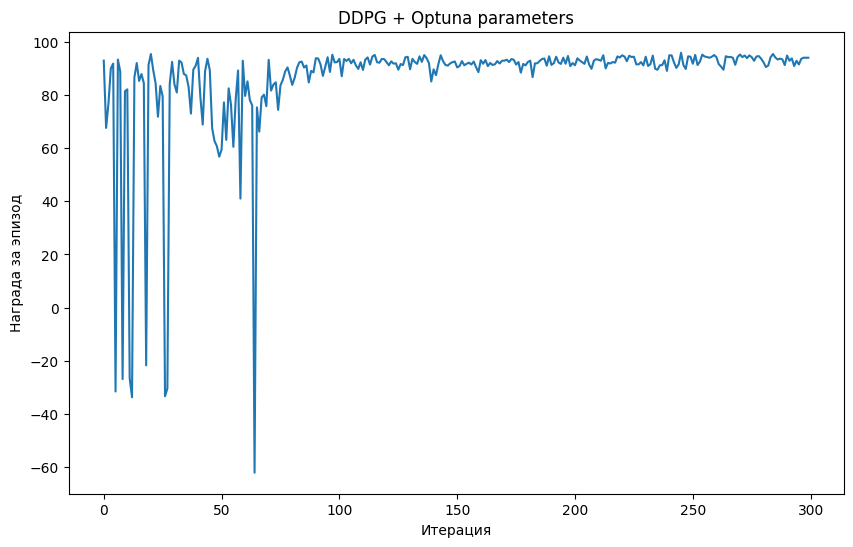

In [23]:
plt.figure(figsize=(10,6))
plt.plot(reward_history)
plt.xlabel("Итерация")
plt.ylabel("Награда за эпизод")
plt.title("DDPG + Optuna parameters")
plt.savefig("graph")

In [ ]:
#Обучение стабильно